# 0. Summary

The notebook primarily focuses on transfer learning with several pre-trained models in TensorFlow/Keras. Here's a summary of the initial structure of the notebook:
1. Imported neccesary libraries
2. Loaded and pre-process the dataset excatly the same way was provided in the initial jupyternotebook file
3. Trained and evaluated the model using VGG16 architecture
4.  tried two other transfer learning architectures(ResNet50 and ) to compare the results

The pretrained weights of the VGG16 model are based on the ImageNet dataset, which uses input dimensions of 224×224×3. Although the minimum input size (32x32x3) allows the model to be successfully created, using pretrained weights may not be suitable for such a small input size, as the convolutional layers in VGG16 are designed for larger images. While increasing the input size could be an option, computational resources are limited, so the smallest viable size was chosen.

However, the input images are 30x30 grayscale, whereas pretrained models like VGG16 and ResNet are trained on 224x224 RGB images, such as those in the ImageNet dataset. These models capture rich features from large, colored images, but such features may not transfer well to smaller grayscale images. As a result, transfer learning may not have provided significant improvements in this context.

Since the input images are single-channel grayscale, and models like VGG16 are designed for three-channel RGB images, directly feeding grayscale images into these models may not fully leverage their feature extraction capabilities. Grayscale images inherently contain less information, so a simpler convolutional network, such as the baseline model, may already be sufficient for this task.

Additionally, pretrained models like VGG16 and ResNet contain an extremely large number of parameters (often over a hundred million), which can be overly complex for a small dataset and relatively simple task, leading to overfitting. In contrast, the baseline model is simpler, with fewer parameters, making it more suitable for smaller datasets.

# 1. Import libraries

In [38]:
# Import necessary libraries
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns

from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.preprocessing.image import DirectoryIterator
from sklearn.model_selection import KFold
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet121


from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score


# From here, add any libraries that you might need for the rest of your code
# Check if running in Google Colab
try:
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Mount Google Drive if in Google Colab
if IN_COLAB:
    drive.mount('/content/drive', force_remount=True)  # Mounts Google Drive for each user in Colab
    print("Google Drive mounted successfully in Colab.")

else:
    # If running in a local Jupyter Notebook, ensure the necessary path is set
    print("Running outside Google Colab. Please ensure necessary paths are correctly set in Jupyter Notebook.")


Mounted at /content/drive
Google Drive mounted successfully in Colab.


# 2. Load and pre-process the dataset

In [30]:
# Set the paths based on your Drive directory
data_dir ='/content/drive/MyDrive/Colab Notebooks/Deep Learning/assignement/data' # Change to the path to your directory

train_images_dir = os.path.join(data_dir, 'Training')
test_images_dir = os.path.join(data_dir, 'Testing')

print(f"Data directory: {data_dir}")
print(f"Training directory: {train_images_dir}")
print(f"Testing directory: {test_images_dir}")

Data directory: /content/drive/MyDrive/Colab Notebooks/Deep Learning/assignement/data
Training directory: /content/drive/MyDrive/Colab Notebooks/Deep Learning/assignement/data/Training
Testing directory: /content/drive/MyDrive/Colab Notebooks/Deep Learning/assignement/data/Testing


*   This code loads images from directories, adds noise to them, rescales them, and prepares them for training/testing
*   Training data is shuffled and processed in batches of 32 images.
    *   Shuffle for Training: Helps the model generalize by presenting the data in a different order, reducing the risk of model overfitting or learning the order of the data.
    *   No shuffle for Testing: It keeps the test data in the same order, so the evaluation is consistent and reliable.

*   The images are resized to 30x30 pixels, and their pixel values are normalized between 0 and 1.
*   Classes are one-hot encoded, which is important for multi-class classification problems.





In [31]:
## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.

# Load and preprocess the data
# add_noise : To add random Gaussian noise to each image, which can help the model generalize better by preventing it from memorizing training data
np.random.seed(seed=42)
def add_noise(img):
    std_coeff = 70*np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

image_res = 30 # resized to 30x30 pixels for processing
def get_images(train_dir: str, test_dir: str):
    datagen = ImageDataGenerator(rescale=1./255, # Rescales image pixel values from [0,255] to [0,1]
                                 preprocessing_function=add_noise)

    img_height, img_width = image_res, image_res
    batch_size = 32

    # Load training data
    train_data = datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width), # Resizes every image to 30x30 pixels
        batch_size=batch_size, # Loads 32 images at a time
        class_mode='categorical', # One-hot encoding happens here
        shuffle=True,
        color_mode='grayscale' # they only have one color channel(insted of three for RGB)
    )

    # Load test data
    test_data = datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width), # Resizes every image to 30x30 pixels
        batch_size=batch_size, # Loads 32 images at a time
        class_mode='categorical', # One-hot encoding happens here
        shuffle=False,
        color_mode='grayscale' # they only have one color channel(insted of three for RGB)
    )

    return train_data, test_data

# Load the training and test data
try:
    train_data, test_data = get_images(train_images_dir, test_images_dir)
    print("Data loading completed successfully.")
    print(f"Number of training samples: {train_data.samples}")
    print(f"Number of test samples: {test_data.samples}")
    print(f"Class names: {train_data.class_indices}")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Found 5712 images belonging to 4 classes.
Found 1331 images belonging to 4 classes.
Data loading completed successfully.
Number of training samples: 5712
Number of test samples: 1331
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


*   Create a bar plot to visulaize the class label distribution of the dataset




# 3. Train and Evaluation functions using VGG16 architecture

*   Implement the transferlearning algorithm without any modification for both model and dataset.

1. change the dataset image size to 32 * 32 in order to fit the transfer leaerning models;
2. train a new model using transfer learning. Utilized VGG16 architecture for feature extraction. Freeze the layers until the fully connected layer such that these layers will not be updated through training. Add fully connected layers.
3. present the results obtained on the test set (ROC curve with AUC score, performance measures, and confusion matrix).

**3.1 change the dataset image size to 32 * 32 in order to fit the transfer leaerning models**

Since all the transfer learning models expects 3-channel (RGB) images of a specific size, this code performs the necessary preprocessing steps:
1. Convert grayscale to RGB: So the input matches the 3-channel format expected by VGG16.
2. Resize images to 32x32: To adapt the smaller input size to the model's requirements.
3. Check shapes: To verify that each transformation has been applied correctly and the data is ready for model input.

In [35]:
# Collect all images and labels from the train_data generator
x_data = []
y_data = []

# Loop through the generator to collect data
for i in range(len(train_data)):
    images, labels = next(train_data)
    x_data.extend(images)
    y_data.extend(labels)

# Convert lists to NumPy arrays
x_data = np.array(x_data)
y_data = np.array(y_data)

# Split into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Now you can use x_train, y_train for training and x_val, y_val for validation.
print("Split the training and validation data successfully.")
print(f"Number of training samples: {len(x_train)}")  # Should show 80% of total
print(f"Number of validation samples: {len(x_val)}")  # Should show 20% of total
print(f"Number of validation samples: {test_data.samples}")


Split the training and validation data successfully.
Number of training samples: 4569
Number of validation samples: 1143
Number of validation samples: 1331


In [43]:
# Create a tensorFlow Dataset for your validation data
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(32)  # Set batch size to match other data generators


In [45]:
# Define the class names corresponding to your data
class_names = ['glioma', 'meningioma', 'no tumor', 'pituitary']


In [46]:
# check the dataset shape before implementing transfer learning
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")
# Collect all images and labels from the train_data generator
x_test = []
y_test = []

# Loop through the generator to collect data
for i in range(len(test_data)):
    images, labels = next(test_data)
    x_test.extend(images)
    y_test.extend(labels)

# Convert lists to NumPy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

print(f"x_test shape: {x_test.shape}")

x_train shape: (4570, 30, 30, 1)
y_train shape: (4570, 4)
x_val shape: (1142, 30, 30, 1)
y_val shape: (1142, 4)
x_test shape: (1331, 30, 30, 1)


In [62]:
# Convert to RGB image
def convert_gray_to_rgb(x):
    return np.stack((x,) * 3, axis=-1)  # Convert single-channel grayscale image to three-channel RGB

# Convert training set, validation set, and test set to RGB and remove extra dimensions
x_train_rgb = np.array([convert_gray_to_rgb(np.squeeze(img)) for img in x_train])
x_val_rgb = np.array([convert_gray_to_rgb(np.squeeze(img)) for img in x_val])
x_test_rgb = np.array([convert_gray_to_rgb(np.squeeze(img)) for img in x_test])

# Check the shape of x_train_rgb, x_val_rgb, and x_test_rgb
print(f"x_train_rgb shape before resize: {x_train_rgb.shape}")
print(f"x_val_rgb shape before resize: {x_val_rgb.shape}")
print(f"x_test_rgb shape before resize: {x_test_rgb.shape}")

# Resize the Images to 32x32 for the Modified VGG16 Model
x_train_resized = tf.image.resize(x_train_rgb, [32, 32]).numpy()
x_val_resized = tf.image.resize(x_val_rgb, [32, 32]).numpy()
x_test_resized = tf.image.resize(x_test_rgb, [32, 32]).numpy()

# Check the resized shapes
print(f"x_train_resized shape: {x_train_resized.shape}")
print(f"x_val_resized shape: {x_val_resized.shape}")
print(f"x_test_resized shape: {x_test_resized.shape}")


x_train_rgb shape before resize: (4570, 30, 30, 3)
x_val_rgb shape before resize: (1142, 30, 30, 3)
x_test_rgb shape before resize: (1331, 30, 30, 3)
x_train_resized shape: (4570, 32, 32, 3)
x_val_resized shape: (1142, 32, 32, 3)
x_test_resized shape: (1331, 32, 32, 3)


**3.2 train a new model using transfer learning.**


we use VGG16 architecture for feature extraction. Freeze the layers until the fully connected layer such that these layers will not be updated through training. Add fully connected layers.

In [65]:
# Load the VGG16 model with ImageNet weights, exclude the top layer
vgg_model = VGG16(include_top=False, input_shape=(32, 32, 3), weights='imagenet', pooling = max)

# Freeze all layers
for layer in vgg_model.layers:
    layer.trainable = False

# Add new classifier layers
flat1 = layers.Flatten()(vgg_model.layers[-1].output)
class1 = layers.Dense(256, activation='relu')(flat1)
output = layers.Dense(4, activation='softmax')(class1)  # Assuming 4 classes in the dataset

# Create new model
vgg_model = models.Model(inputs=vgg_model.inputs, outputs=output)

# Compile the model
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
vgg_model.summary()


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 2, 2, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,847,044 (56.64 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

we train the model using the suitable dataset we converted.

In [67]:
# Train the model
history_vgg = vgg_model.fit(x_train_resized, y_train, validation_data=(x_val_resized, y_val), epochs=10, verbose=1)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 87s 607ms/step - accuracy: 0.6835 - loss: 0.7830 - val_accuracy: 0.6681 - val_loss: 0.8251
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 137s 574ms/step - accuracy: 0.6965 - loss: 0.7570 - val_accuracy: 0.6856 - val_loss: 0.7644
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 593ms/step - accuracy: 0.7251 - loss: 0.6878 - val_accuracy: 0.6751 - val_loss: 0.7692
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 141s 586ms/step - accuracy: 0.7115 - loss: 0.7324 - val_accuracy: 0.6891 - val_loss: 0.7915
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 143s 593ms/step - accuracy: 0.7349 - loss: 0.6931 - val_accuracy: 0.6883 - val_loss: 0.7434
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 141s 591ms/step - accuracy: 0.7288 - loss: 0.6670 - val_accuracy: 0.7154 - val_loss: 0.7052
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 142s 592ms/step - accuracy: 0.7431 - loss: 0.6301 - val_accuracy: 0.7084 - val_loss: 0.7172
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 153s 669ms/step - accuracy: 0.7483 - l

**3.3 present the results obtained on the test set (ROC curve with AUC score, performance measures, and confusion matrix).**

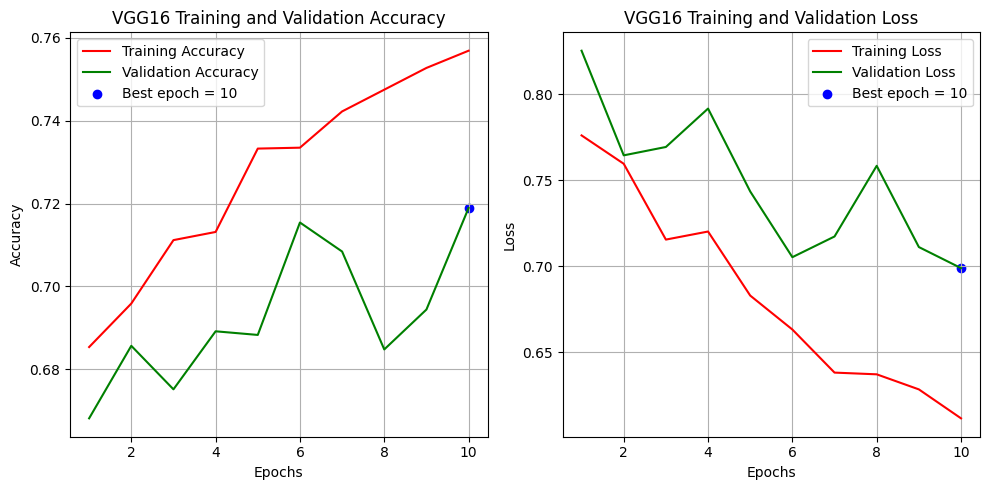

In [68]:
# revise plot function provided from baseline model
np.random.seed(42)

def plot_training_history(history, model_name='Model'):
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'r', label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'g', label='Validation Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')  # Use model_name in the title
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Highlight the best epoch for validation accuracy
    best_epoch_acc = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
    plt.scatter(best_epoch_acc, max(history.history['val_accuracy']), label=f'Best epoch = {best_epoch_acc}', color='blue')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'r', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'g', label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')  # Use model_name in the title
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Highlight the best epoch for validation loss based on the best validation accuracy epoch
    plt.scatter(best_epoch_acc, history.history['val_loss'][best_epoch_acc - 1], label=f'Best epoch = {best_epoch_acc}', color='blue')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function with the history object returned from model.fit() and the name of the model
plot_training_history(history_vgg, model_name='VGG16')


In [69]:
# revise plot function provided from baseline model to draw multiclass_roc_and_confusion_matrix
def plot_multiclass_roc_and_confusion_matrix(model, x_test, y_test, class_names, set_type='Test'):
    y_pred = model.predict(x_test)

    # Convert y_test from one-hot encoding to integer labels
    y_test_classes = np.argmax(y_test, axis=1)

    # Collect model predictions (in probabilities) and convert them to class labels
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Binarize the true labels for ROC calculation (for multi-class)
    y_test_binarized = label_binarize(y_test_classes, classes=[0, 1, 2, 3])
    n_classes = y_test_binarized.shape[1]

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves and Confusion Matrix
    plt.figure(figsize=(12, 6))

    # Plot ROC curve
    plt.subplot(1, 2, 1)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {set_type} Set')
    plt.legend(loc="lower right")

    # Plot Confusion Matrix
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix for {set_type} Set')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 449ms/step


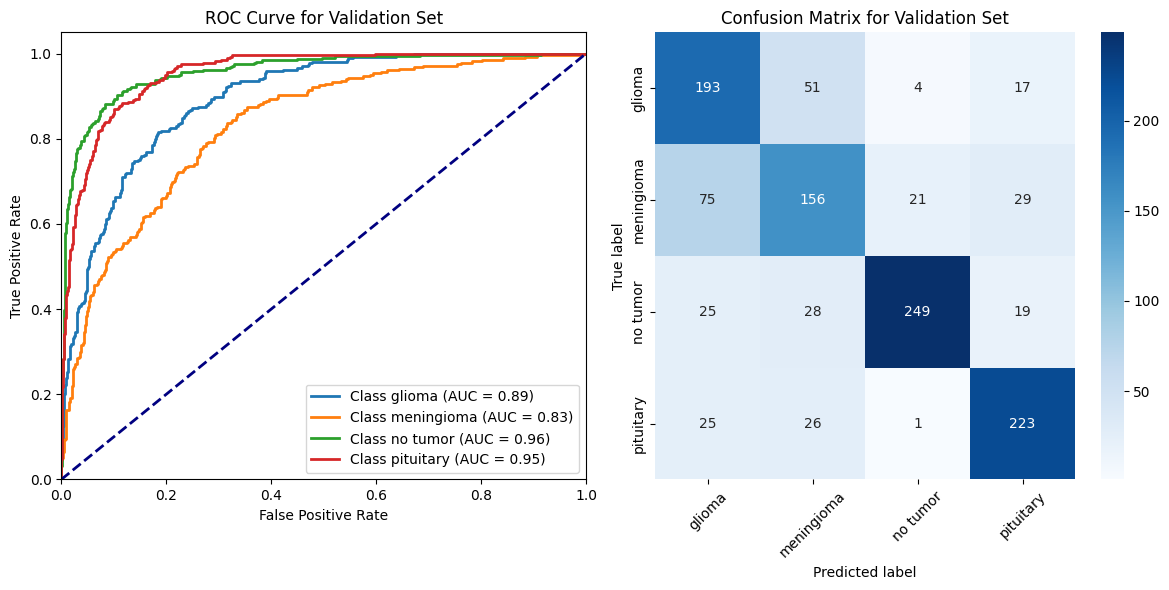

42/42 ━━━━━━━━━━━━━━━━━━━━ 18s 432ms/step


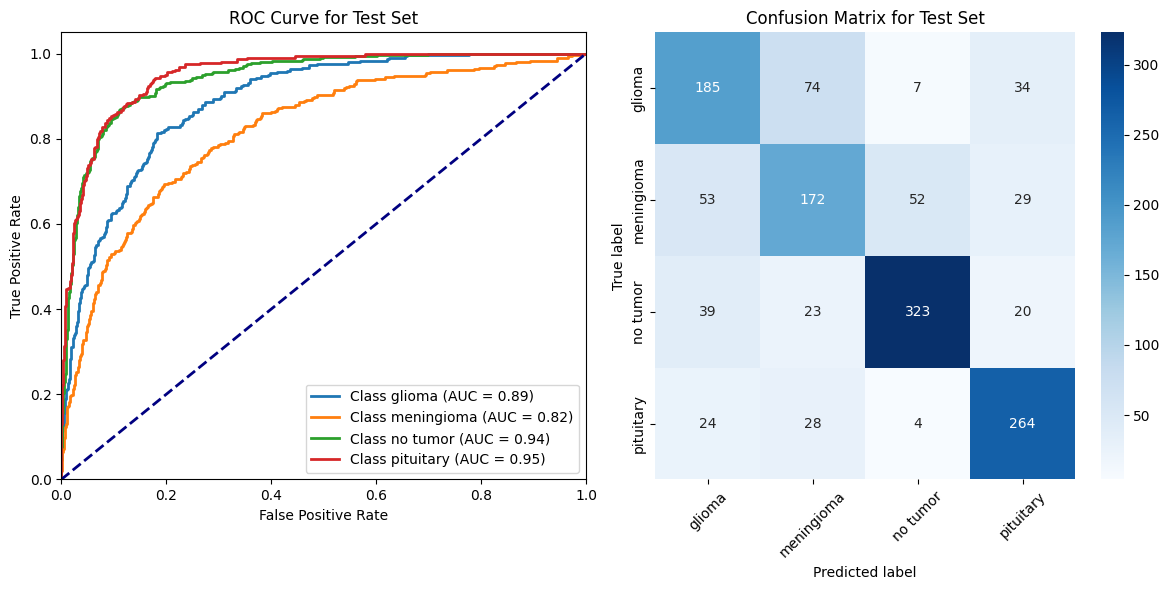

In [70]:
# Define the class names
class_names = ['glioma', 'meningioma', 'no tumor', 'pituitary']


# Call the function to plot ROC curve and confusion matrix
plot_multiclass_roc_and_confusion_matrix(vgg_model, x_val_resized, y_val, class_names, set_type='Validation')
plot_multiclass_roc_and_confusion_matrix(vgg_model, x_test_resized, y_test, class_names, set_type='Test')

# 4. Tried two other transfer learning models to compare the results.
1.  ResNet50 Transfer Learning:

In [71]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Load the ResNet50 model with ImageNet weights, exclude the top layer
resnet_model = ResNet50(include_top=False, input_shape=(32, 32, 3), weights='imagenet', pooling = max)

# Freeze all layers
for layer in resnet_model.layers:
    layer.trainable = False

# Add new classifier layers
flat1 = layers.Flatten()(resnet_model.layers[-1].output)
class1 = layers.Dense(256, activation='relu')(flat1)
output = layers.Dense(4, activation='softmax')(class1)  # Assuming 4 classes in the dataset

# Create new model
resnet_model = models.Model(inputs=resnet_model.inputs, outputs=output)

# Compile the model
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
resnet_model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [72]:

# Train the model
history_resnet = resnet_model.fit(x_train_resized, y_train, validation_data=(x_val_resized, y_val), epochs=10, verbose=1)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 267ms/step - accuracy: 0.3211 - loss: 1.6320 - val_accuracy: 0.5009 - val_loss: 1.1675
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 36s 233ms/step - accuracy: 0.4598 - loss: 1.1865 - val_accuracy: 0.4711 - val_loss: 1.1717
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 240ms/step - accuracy: 0.4953 - loss: 1.1379 - val_accuracy: 0.5254 - val_loss: 1.0787
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 217ms/step - accuracy: 0.5231 - loss: 1.0877 - val_accuracy: 0.5166 - val_loss: 1.1537
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 210ms/step - accuracy: 0.5399 - loss: 1.0546 - val_accuracy: 0.5429 - val_loss: 1.0439
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 45s 241ms/step - accuracy: 0.5587 - loss: 1.0242 - val_accuracy: 0.5683 - val_loss: 1.0081
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 215ms/step - accuracy: 0.5760 - loss: 1.0032 - val_accuracy: 0.5867 - val_loss: 0.9787
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 35s 245ms/step - accuracy: 0.5736 - loss: 0

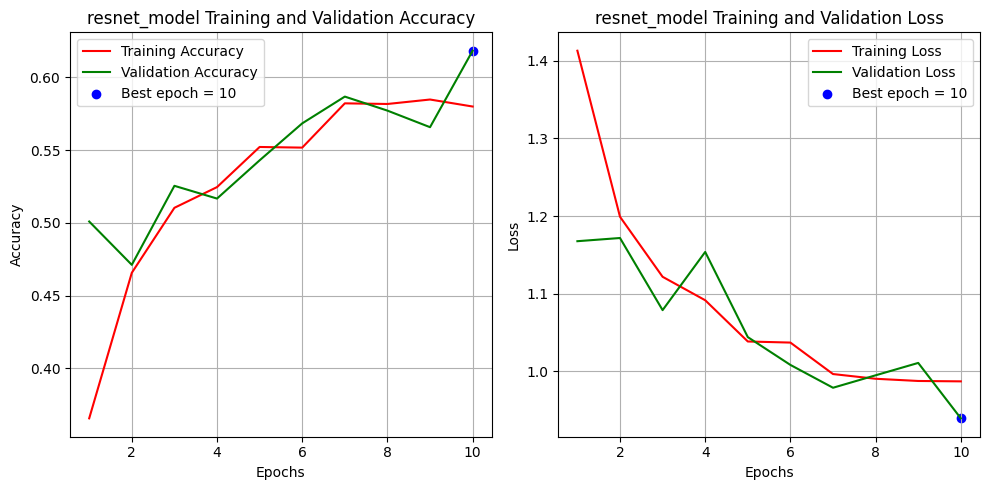

36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 215ms/step


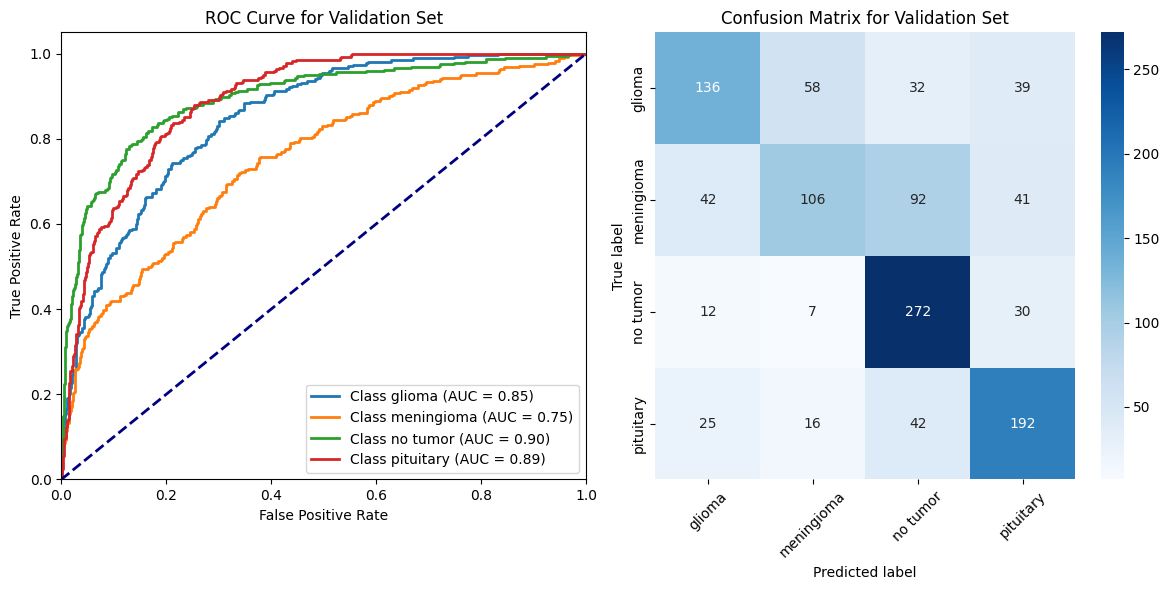

42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step


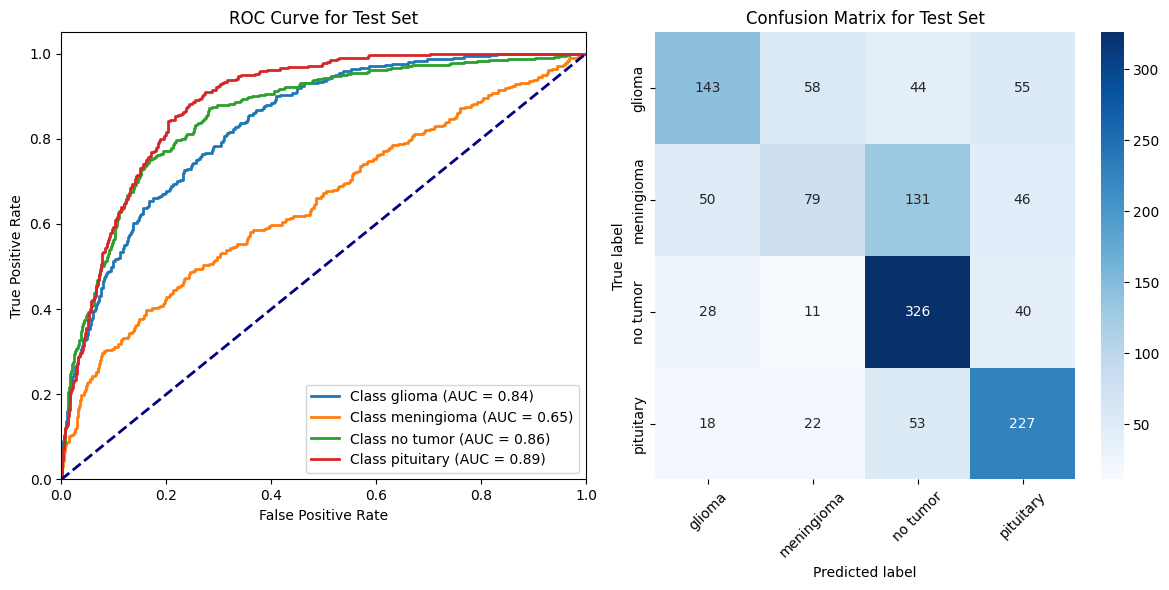

In [73]:
# Call the function with the history object returned from model.fit() and the name of the model
plot_training_history(history_resnet, model_name='resnet_model')
# Call the function to plot ROC curve and confusion matrix
plot_multiclass_roc_and_confusion_matrix(resnet_model, x_val_resized, y_val, class_names, set_type='Validation')
plot_multiclass_roc_and_confusion_matrix(resnet_model, x_test_resized, y_test, class_names, set_type='Test')

2. DenseNet121 Transfer Learning:

In [74]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models

# Load the DenseNet121 model with ImageNet weights, exclude the top layer
densenet_model = DenseNet121(include_top=False, input_shape=(32, 32, 3), weights='imagenet', pooling =max)

# Freeze all layers
for layer in densenet_model.layers:
    layer.trainable = False

# Add new classifier layers
flat1 = layers.Flatten()(densenet_model.layers[-1].output)
class1 = layers.Dense(256, activation='relu')(flat1)
output = layers.Dense(4, activation='softmax')(class1)  # Assuming 4 classes in the dataset

# Create new model
densenet_model = models.Model(inputs=densenet_model.inputs, outputs=output)

# Compile the model
densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
densenet_model.summary()



Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_4          │ (None, 38, 38, 3)      │              0 │ input_layer_12[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,408 │ zero_padding2d_4[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_5          │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 8, 8, 64)       │              0 │ zero_padding2d_5[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 8, 8, 64)       │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 128)      │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 128)      │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 128)      │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 32)       │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 8, 8, 96)       │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,300,932 (27.85 MB)

 Trainable params: 263,428 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [75]:

# Train the model
history_densenet = densenet_model.fit(x_train_resized, y_train, validation_data=(x_val_resized, y_val), epochs=10, verbose=1)

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 56s 263ms/step - accuracy: 0.5106 - loss: 1.1518 - val_accuracy: 0.6331 - val_loss: 0.8465
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 26s 182ms/step - accuracy: 0.6820 - loss: 0.7365 - val_accuracy: 0.6786 - val_loss: 0.7641
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 43s 199ms/step - accuracy: 0.7326 - loss: 0.6518 - val_accuracy: 0.6708 - val_loss: 0.8057
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 195ms/step - accuracy: 0.7541 - loss: 0.6254 - val_accuracy: 0.6734 - val_loss: 0.7804
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 44s 220ms/step - accuracy: 0.7590 - loss: 0.5909 - val_accuracy: 0.6804 - val_loss: 0.7692
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 44s 243ms/step - accuracy: 0.7851 - loss: 0.5289 - val_accuracy: 0.6944 - val_loss: 0.7397
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 221ms/step - accuracy: 0.7925 - loss: 0.5137 - val_accuracy: 0.6655 - val_loss: 0.7869
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 199ms/step - accuracy: 0.8032 - loss: 0

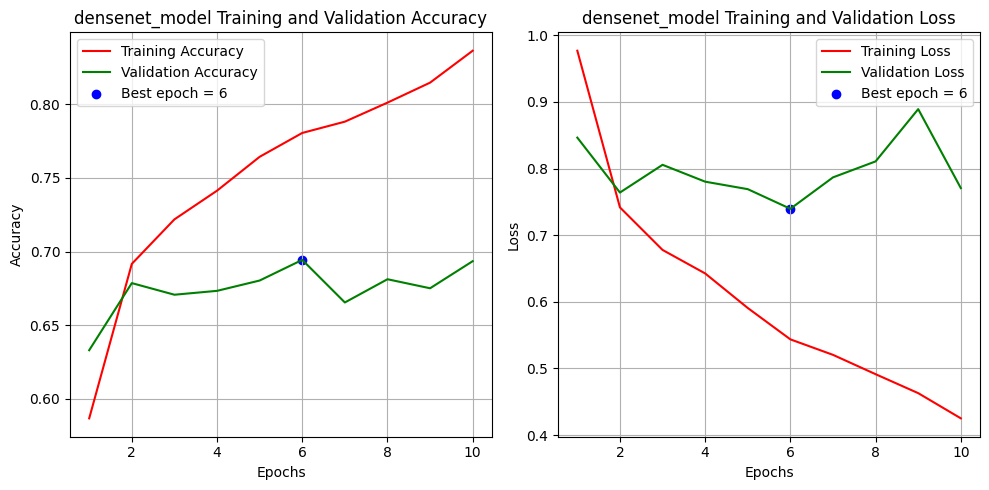

36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 318ms/step


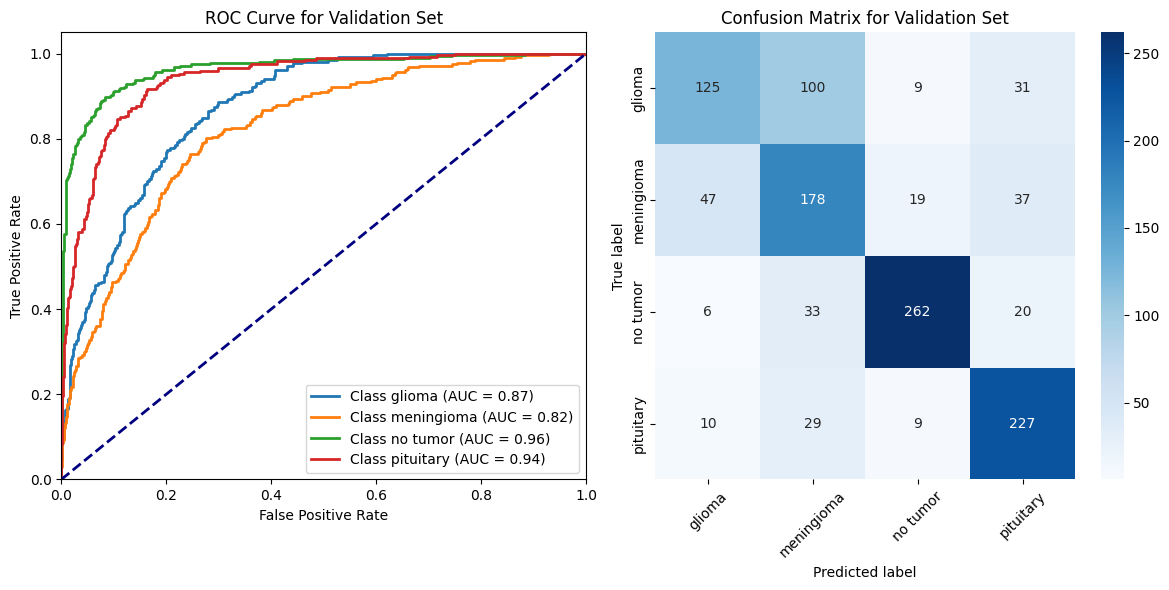

42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step


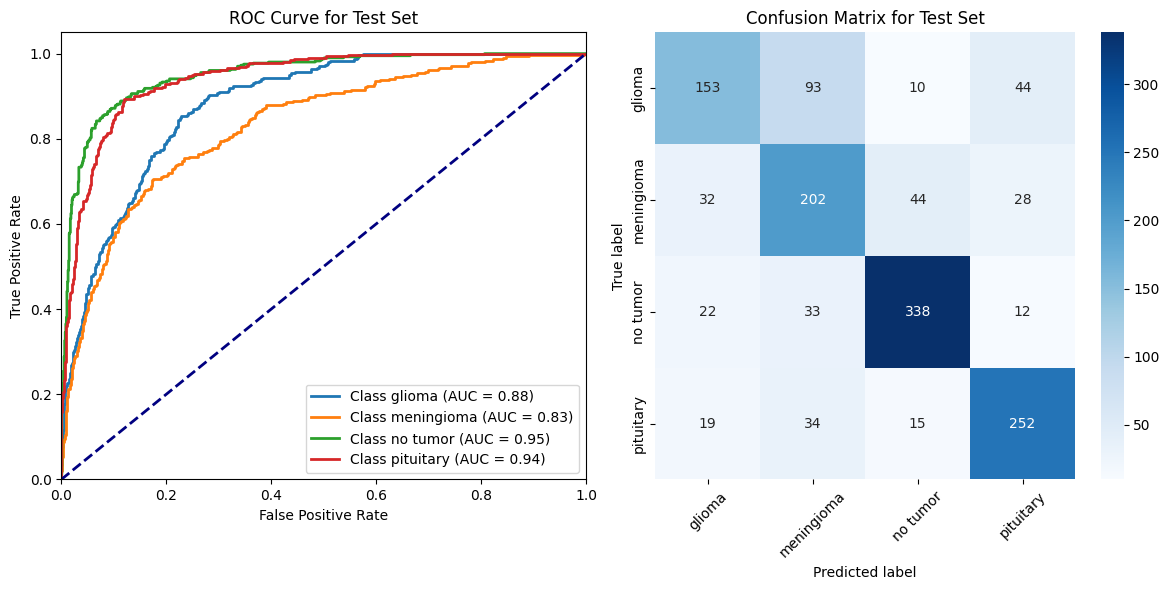

In [76]:
# Call the function with the history object returned from model.fit() and the name of the model
plot_training_history(history_densenet, model_name='densenet_model')
# Call the function to plot ROC curve and confusion matrix
plot_multiclass_roc_and_confusion_matrix(densenet_model, x_val_resized, y_val, class_names, set_type='Validation')
plot_multiclass_roc_and_confusion_matrix(densenet_model, x_test_resized, y_test, class_names, set_type='Test')